# test some hybrid models to potentially add to `stancode_gallery2`
 * using all of the data for training (`i_test[:] = 0`)
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np
import pandas as pd
import dateutil.parser

# create plots of the data
show_data = True

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

# Now we load in count data
for dataname in datafiles:

    if 'seaflow' in dataname:
        # Extract SeaFlow cell counts
        seaflow = pd.read_csv('data/SeaFlow_PSD_hourlyCOUNT_m32.csv')
        seaflow_counts = seaflow.values[:, 2:].T.astype(int)

        # Redefine parameters to match 32-size class count data. We only keep PAR from the 25-size class data.
        data_gridded[dataname]['m'] = seaflow_counts.shape[0]
        data_gridded[dataname]['size_bounds'] = seaflow.columns[2:].values.astype(float) # extract size classes from dataframe
        data_gridded[dataname]['v_min'] = data_gridded[dataname]['size_bounds'][0] # note these seem to be on a different scale
        data_gridded[dataname]['delta_v_inv'] = int(np.round(1.0/np.log2(data_gridded[dataname]['size_bounds'][1]/data_gridded[dataname]['size_bounds'][0])))
        data_gridded[dataname]['w_obs'] = (seaflow_counts/np.sum(seaflow_counts, axis=0)[None, :]).astype(float)
        data_gridded[dataname]['counts'] = seaflow_counts
        data_gridded[dataname]['obs_time'] = np.empty(shape=seaflow_counts.shape[1])

        # Extract time stamps for each observation from SeaFlow data
        ii = 0
        for timestamp in np.asarray(seaflow['time'], dtype=str):
            datetime = dateutil.parser.isoparse(timestamp)
            if ii == 0:
                initial = datetime
            data_gridded['seaflow']['obs_time'][ii] = (datetime - initial).total_seconds()/60
            ii += 1

    elif 'zinser' in dataname:

        # Extract Zinser cell counts
        zinser = pd.read_csv('data/Zinser_Figure2A.csv')
        #zinser_counts = zinser.values[:,1].astype(int) # cells A column
        #zinser_counts = zinser.values[:,2].astype(int) # cells B column
        zinser_counts = np.mean(zinser.values, axis=1).astype(int) # mean of both columns
        
        # Add counts to Zinser data
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['w_obs'] * zinser_counts).astype(int)
        data_gridded[dataname]['obs_time'] = data_gridded[dataname]['time']

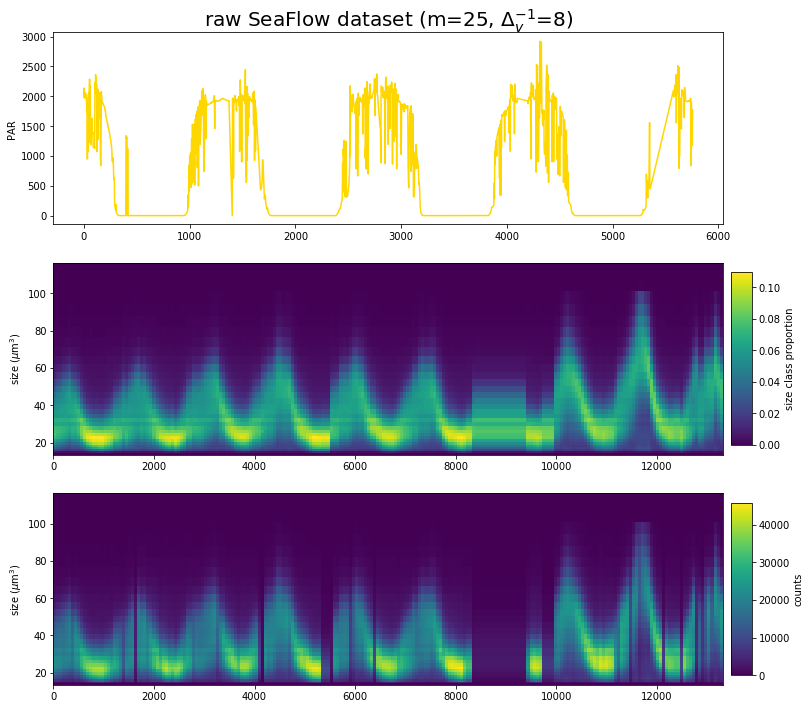

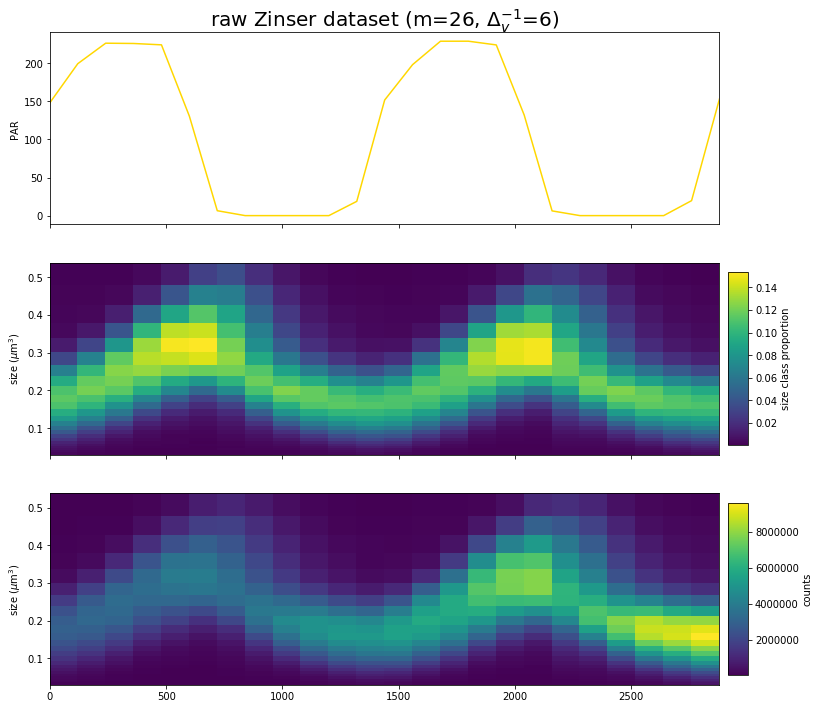

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if show_data:
    for i,dataname in enumerate(data_gridded):
        nrows = 3
        sharex = np.array_equal(data_gridded[dataname]['time'], data_gridded[dataname]['obs_time'])

        v_min = data_gridded[dataname]['v_min']
        delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

        fig,axs = plt.subplots(nrows=nrows, sharex=sharex, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('raw '+desc[dataname], size=20)
        ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
        ax.set(ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['w_obs'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        pc = ax.pcolormesh(data_gridded[dataname]['obs_time'],v,data_gridded[dataname]['counts'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
                
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['obs_time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # set all indices to zero
    data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

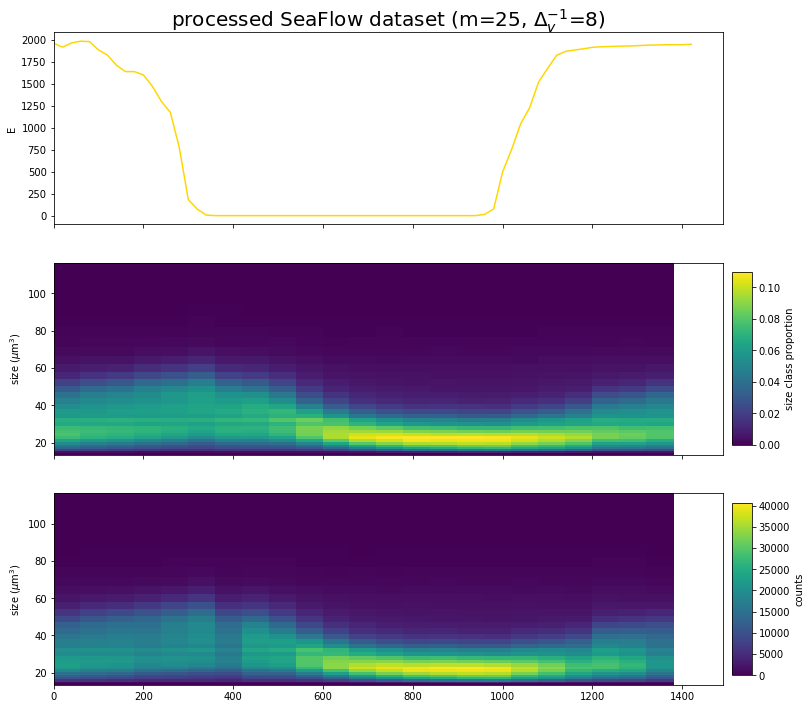

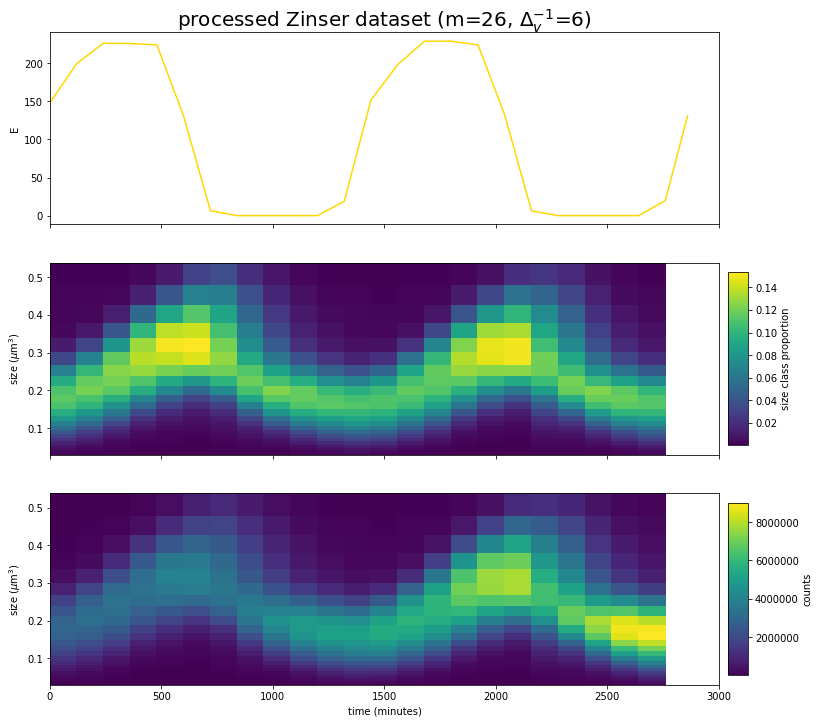

In [4]:
if show_data:
    for i,dataname in enumerate(data):
        nrows = 3

        v_min = data[dataname]['v_min']
        delta_v = 1.0/data[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
        t = np.arange(data[dataname]['nt'])*data[dataname]['dt']


        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('processed '+desc[dataname], size=20)
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(ylabel='E')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
        ax.set_xlim(left=0.0)

        ax = axs[2]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs_count'])
        ax.set(ylabel='size ($\mu$m$^3$)')
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
        ax.set_xlim(left=0.0)
    axs[-1].set_xlabel('time (minutes)')
None

## run model

In [5]:
import pystan
import re

desc_model = {
    #'s1':'m1',
    #'s2':'m2',
    #'s3':'m3',
    #'s4':'m4',
    's5':'m5',
    's6':'m6',
    's7':'m7',
    #'s8':'m8',
    #'s9':'m9',
    #'s10':'m10',
    's11':'m5 + size-dep growth (m5-m6 hybrid)',
    's12':'m5 + size-dep growth (m5-m7 hybrid)',
}
# preparing for some regular expression magic
model_code_replacements = {
    's1':(),
    's2':(),
    's3':(),
    's4':(),
    's5':(),
    's6':(),
    's7':(),
    's8':(),
    's9':(),
    's10':(),
    's11':(),
    's12':(),
}
model_stan_key = {
    's1':'c1',
    's2':'c2',
    's3':'c3',
    's4':'c4',
    's5':'c5',
    's6':'c6',
    's7':'c7',
    's8':'c8',
    's9':'c9',
    's10':'c10',
    's11':'c56',
    's12':'c57',
}
stan_files = {
    'c1':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowth_xval2.stan',
    'c2':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowth_xval2.stan',
    'c3':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c4':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowth_xval2.stan',
    'c5':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowth_xval2.stan',
    'c6':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowth_xval2.stan',
    'c7':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowth_xval2.stan',
    'c8':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowth_xval2.stan',
    'c9':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowth_xval2.stan',
    'c10':'stancode_gallery2/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowth_xval2.stan',
    'c56':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowth_xval2.stan',
    'c57':'stancode/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowth_xval2.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for name in desc_model:
    code_split = stan_base_code[model_stan_key[name]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[name]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(name, line_new))
        code_split_new.append(line_new)
                
    stan_code[name] = '\n'.join(code_split_new)

for name in desc_model:
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code[name]:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(model_code=stan_code[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL s5 NOW.


s5: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s6 NOW.


s6: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s7 NOW.


s7: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s11 NOW.


s11: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL s12 NOW.


s12: compiling


In [6]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}

try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (m5)
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_max           34.17    0.18    7.95   21.71   28.57   33.02   38.65   52.81   1847    1.0
gamma_max            1.48  1.5e-3    0.07    1.37    1.43    1.47    1.51    1.63   2256    1.0
rho_max            7.1e-4  8.2e-6  7.2e-4  1.9e-5  2.1e-4  4.9e-4  9.7e-4  2.6e-3   7664    1.0
E_star             188.81     3.8  160.48   41.75   80.71  130.65  243.02  628.83   1783    1.0
sigma              916.85    0.54   44.39  829.83  886.92  916.34  945.93  1007.3   6763    1.0
divrate              0.72  4.0e-4    0.02    0.67     0.7    0.72    0.74    0.76   3740    1.0
delta[1]           3.3e-4  3.7e-6  3.2e-4  9.1e-6  9.9e-5  2.3e-4  4.4e-4  1.2e-3   7290    1.0
delta[2]             0.27  4.3e-4    0.03    0.22    0.26    0.27    0.29   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s5 (m5)
Inference for Stan model: s5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
delta_max           23.42    0.15    5.26   15.84   20.04   22.57   25.68  36.64   1249    1.0
gamma_max            4.45    0.01    0.35    4.06    4.24    4.38    4.58   5.22   1086    1.0
rho_max              1.57  1.3e-3    0.06    1.44    1.52    1.56    1.61   1.69   2358    1.0
E_star               86.0    0.69   24.18   52.86   71.08   82.08   96.75 138.35   1239    1.0
sigma              393.61    0.37   22.72  350.24  378.07  393.43  408.61 440.46   3857    1.0
divrate              0.61  6.9e-4    0.04    0.52    0.58    0.61    0.64   0.69   3883    1.0
delta[1]           8.6e-3  1.1e-4  7.8e-3  2.2e-4  2.7e-3  6.4e-3    0.01   0.03   5293    1.0
delta[2]             0.02  1.4e-4    0.01  2.7e-3  9.3e-3    0.02    0.02   0.04   5

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6 (m6)
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_max           53.79    0.17    8.13    39.2   47.78   53.26   59.62   69.84   2163    1.0
gamma_max            4.96  2.4e-3    0.19    4.45    4.88    5.02    5.11    5.16   6561    1.0
rho_max              2.34    0.02    1.52    0.06    0.97    2.22    3.65    5.01   9843    1.0
E_star             110.65    1.16   73.04   34.54   64.02   89.01  132.19  315.93   3947    1.0
sigma              1032.6    0.57    52.1  934.15  996.91  1031.9  1066.9  1138.5   8297    1.0
xi                   0.01  7.5e-6  5.7e-4    0.01    0.01    0.01    0.01    0.01   5856    1.0
xir                  0.14  8.9e-4    0.05    0.07    0.11    0.13    0.17    0.26   3075    1.0
divrate              0.77  3.1e-4    0.02    0.73    0.76    0.77    0.79   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s6 (m6)
Inference for Stan model: s6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
delta_max             2.7  6.2e-3     0.4    2.01    2.42    2.67    2.95   3.57   4167    1.0
gamma_max            5.27  3.1e-3    0.19    4.95    5.14    5.25    5.38   5.71   4048    1.0
rho_max              2.09  1.2e-3    0.08    1.93    2.03    2.09    2.14   2.25   4797    1.0
E_star              79.48    0.19   11.51   60.07   72.08   78.34   85.45 106.89   3713    1.0
sigma              625.28    0.61   37.56   554.5  599.64   624.2   650.1 702.04   3774    1.0
xi                  -1.16  1.1e-3    0.08   -1.31   -1.21   -1.16    -1.1  -1.01   4857    1.0
xir                  0.49  1.1e-3    0.08    0.33    0.43    0.49    0.54   0.65   5938    1.0
divrate              0.33  4.2e-4    0.03    0.28    0.32    0.33    0.35   0.39   4

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7 (m7)
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_max            53.58     0.2    8.35   38.72   47.47   53.06   59.58   70.14   1737    1.0
gamma_max             4.95  2.4e-3     0.2    4.41    4.87    5.01     5.1    5.16   7262    1.0
rho_max               2.38    0.02    1.52    0.07    1.05     2.3    3.66    5.04   9261    1.0
E_star              111.29    1.21   73.15   35.88   65.89   89.88  130.68  326.49   3643    1.0
sigma               1032.9    0.54   51.23  935.04  997.98  1031.6  1068.0  1134.5   9019    1.0
xi                    0.01  7.4e-6  5.8e-4    0.01    0.01    0.01    0.01    0.01   6078    1.0
xir                   0.14  9.0e-4    0.05    0.07    0.11    0.13    0.17    0.26   2967    1.0
divrate               0.77  3.1e-4    0.02    0.73    0.76    0.77  

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s7 (m7)
Inference for Stan model: s7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_max           37.16    0.13    5.77   27.13   33.18   36.71   40.72   49.75   1950    1.0
gamma_max            8.15    0.01     0.5    6.91    7.84    8.24    8.56    8.79   1969    1.0
rho_max               1.5  1.8e-3    0.09    1.33    1.44     1.5    1.56    1.68   2328    1.0
E_star             193.43    0.56   23.85  138.38  178.97  196.29  210.35  233.19   1838    1.0
sigma              343.16    0.37   20.37  303.97  329.47  342.43  356.93   383.4   2967    1.0
xi                  -0.55  1.9e-3    0.11   -0.76   -0.62   -0.55   -0.48   -0.35   3189    1.0
xir                  0.27  1.9e-3     0.1    0.07     0.2    0.27    0.33    0.46   2665    1.0
divrate              0.73  8.6e-4    0.05    0.63    0.69    0.73    0.76   

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s11 (m5 + size-dep growth (m5-m6 hybrid))
Inference for Stan model: s11.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%      75%   97.5%  n_eff   Rhat
delta_max           54.67    0.22    8.25   39.66   48.37   54.39    60.84   70.37   1449    1.0
gamma_max            4.96  2.4e-3    0.19    4.45    4.87    5.01     5.11    5.16   6578    1.0
rho_max            6.8e-4  8.7e-6  6.9e-4  1.6e-5  2.0e-4  4.6e-4   9.2e-4  2.5e-3   6255    1.0
E_star             110.49     1.2   71.07   33.94   65.43   90.14   130.46  312.87   3530    1.0
sigma              1031.9    0.63   52.26  933.89  996.47  1031.7   1066.0  1137.1   6931    1.0
xi                   0.01  7.3e-6  5.7e-4    0.01    0.01    0.01     0.01    0.01   6160    1.0
divrate              0.77  3.3e-4    0.02    0.73    0.76    0.77     0.79    0.81   4353    1.0
delta[1]           2.8e-4  3.8e-6

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


s11 (m5 + size-dep growth (m5-m6 hybrid))
Inference for Stan model: s11.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
delta_max             3.6  8.0e-3    0.52    2.73    3.24    3.55    3.91   4.75   4209    1.0
gamma_max            5.41  3.7e-3    0.21    5.06    5.27    5.39    5.52   5.88   3225    1.0
rho_max              1.75  7.8e-4    0.05    1.66    1.72    1.75    1.78   1.85   4089    1.0
E_star              80.39    0.21   12.06   60.03   72.62   79.38   86.84 107.24   3421    1.0
sigma              618.59    0.69   39.76  542.07  592.18  618.04  645.01 697.66   3301    1.0
xi                   -1.3  1.4e-3    0.08   -1.45   -1.35    -1.3   -1.25  -1.14   3080    1.0
divrate              0.36  4.2e-4    0.03    0.31    0.34    0.36    0.38   0.41   4296    1.0
delta[1]             0.02  2.2e-4    0.01  5.8e-4

Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Traceback (most recent call last):
Process ForkPoolWorker-34:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    s

KeyboardInterrupt: 

KeyboardInterrupt
KeyboardInterrupt


## plot the results

In [ ]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

# set the color for each model
num_model = len(mcmcs)
if num_model <= 10:
    colors_model = {name:'C{}'.format(imodel) for imodel,name in enumerate(mcmcs)}
else:
    colors_model = {name:mpl.cm.viridis(imodel/(num_model-1)) for imodel,name in enumerate(mcmcs)}
    
maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}

In [ ]:
param_desc = {'divrate':'daily division rate','E_star':'E*'}
# add known values here
reference_values = {'zinser':{'divrate':0.69}}

In [ ]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

In [ ]:
# updated code can handle all data[dataname]['i_test'] == 0 and draw only a single bar
if np.all(data[dataname]['i_test'] == 0):
    num_bars = 1
else:
    num_bars = 3

height = np.zeros(num_bars)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        if num_bars > 1:
            height[1] = np.mean(e[data[dataname]['i_test'] == 0])
            height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = (num_bars+1)*i+np.arange(num_bars)
        ax.bar(x=x, height=height, color=colors_model[name])
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(x[num_bars//3], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[num_bars//3])
        xticklabels.append(desc_model[name].replace(',',',\n').replace('(','\n('))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

In [ ]:
for param in ('divrate','E_star'):
    for dataname in data:
        num_mcmcs = len(mcmcs)
        fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
        ax.set_title('{} for {}'.format(param_desc[param], desc[dataname]))
        ax.violinplot([mcmcs[name][dataname][param] for name in mcmcs], showmedians=True, vert=False)
        ax.invert_yaxis()
        ax.grid(axis='x')
        ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
        if dataname in reference_values and param in reference_values[dataname]:
            ax.axvline(reference_values[dataname][param], color='tab:green', lw=3)
        for i,name in enumerate(mcmcs):
            if maxrhats_final[name][dataname] > 1.1:
                ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

In [ ]:
for dataname in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

In [ ]:
data_fig2a = pd.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.15)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
    v = v_ext[:-1]
    v_width = v_ext[1:] - v_ext[:-1]
        
    for name,mcmc in mcmcs.items():
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[name][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()

In [ ]:
'''
import netCDF4 as nc4

for dataname in data:

    ncname = 'data_exp_zs_20200624_gallery2_test_{}.nc'.format(dataname)

    with nc4.Dataset(ncname, 'w') as nc:
        for i,name in enumerate(mcmcs):
            if i == 0:
                nc.createDimension('model', len(mcmcs))
                nc.createDimension('sample', mcmcs[name][dataname]['divrate'].shape[0])
            
                nc.createVariable('divrate', float, ('model','sample'))
                nc.createVariable('sumsqdiff', float, ('model','sample'))
                nc.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')
                
            nc.variables['divrate'][i,:] = mcmcs[name][dataname]['divrate']
            
            obs = data[dataname]['obs']

            tmp = mcmcs[name][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
            
            for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                if i == 0:
                    nc.createVariable(v, float, ('model','sample'))
                if v in mcmcs[name][dataname].flatnames:
                    nc.variables[v][i,:] = mcmcs[name][dataname][v]
'''
None

In [ ]:
for dataname in data:
    if 'zinser' in dataname:
        fig, ax = plt.subplots(figsize=(14,14))

        for name in mcmcs:
            # misfit to data

            obs = data[dataname]['obs']

            tmp = mcmcs[name][dataname]['mod_obspos']
            tmp/= np.sum(tmp, axis=1)[:,None,:]
            tmp -= obs[None,:,:]
            tmp **= 2
            
            if np.all(data[dataname]['i_test'] == 0):
                e0 = np.mean(np.sum(tmp, axis=1), axis=1)
                xlabel_suffix = ''
            else:
                e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                xlabel_suffix = ' (test data)'
            
            # misfit to division rate

            e1 = np.sqrt(np.mean((mcmcs[name][dataname]['divrate'] - reference_values[dataname]['divrate'])**2))
        
            q0 = np.percentile(e0, q=(5,25,50,75,95))
            q1 = np.percentile(e1, q=(5,25,50,75,95))

            eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=model, color=colors_model[name])
            ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())

        ax.grid(True)
        ax.legend()
        ax.set(xlabel='size distribution misfit'+xlabel_suffix, ylabel='daily division rate misfit')
        ax.set_xlim(left=0.0)
        ax.set_ylim(bottom=0.0)

In [ ]:
fig, ax = plt.subplots(figsize=(14,14))

datanames = tuple(data.keys())
for name in mcmcs:
    qq = {}
    # misfit to data
    for dataname in datanames:
        obs = data[dataname]['obs']

        tmp = mcmcs[name][dataname]['mod_obspos']
        tmp/= np.sum(tmp, axis=1)[:,None,:]
        tmp -= obs[None,:,:]
        tmp **= 2

        if np.all(data[dataname]['i_test'] == 0):
            e0 = np.mean(np.sum(tmp, axis=1), axis=1)
        else:
            e0 = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)

        qq[dataname] = np.percentile(e0, q=(5,25,50,75,95))
    
    q0 = qq[datanames[0]]
    q1 = qq[datanames[1]]
    eb = ax.errorbar(x=q0[2], y=q1[2], xerr=np.array((q0[2]-q0[0], q0[-1]-q0[2]))[:,None], marker='o', ms=10, label=model, color=colors_model[name])
    ax.errorbar(x=q0[2], y=q1[2], yerr=np.array((q1[2]-q1[0], q1[-1]-q1[2]))[:,None], color=eb[0].get_color())

ax.grid(True)
ax.legend()
ax.set(xlabel='{} size distribution misfit'.format(desc[datanames[0]]), 
       ylabel='{} size distribution misfit'.format(desc[datanames[0]]))
ax.set_xlim(left=0.0)
ax.set_ylim(bottom=0.0)